# Time Series Preprocessing Pipeline for Flight Delay Data

This notebook builds upon the base preprocessing pipeline to create features specifically optimized for time series models such as ARIMA, Prophet, and other forecasting algorithms. Time series analysis requires specific preprocessing steps including proper temporal aggregation, handling of seasonality, and preparation of lagged features.

## Key Processing Steps:
1. Loading the base preprocessed data
2. Temporal aggregation (daily, hourly)
3. Time series feature engineering (lags, rolling windows)
4. Handling seasonality
5. Stationarity testing and transformations
6. Creation of exogenous variables
7. Time-based train-test splits with forecast horizon
8. Exporting the processed data for time series model training

In [64]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import pickle

# Ignore warnings
warnings.filterwarnings('ignore')

# Configure paths dynamically using relative paths
import os.path as path

# Get the directory of the current notebook
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
BASE_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'base_preprocessed_flights.csv')
TS_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'ts_ready_flights')
TS_MODEL_PATH = path.join(project_root, 'models', 'ts')

# Create directories if they don't exist
os.makedirs(os.path.dirname(TS_PROCESSED_PATH), exist_ok=True)
os.makedirs(TS_MODEL_PATH, exist_ok=True)

print(f"Base processed data path: {BASE_PROCESSED_PATH}")
print(f"Time Series processed data path: {TS_PROCESSED_PATH}")
print(f"Time Series model path: {TS_MODEL_PATH}")

# Display settings
pd.set_option('display.max_columns', None)
print("Libraries and paths configured.")

Base processed data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\base_preprocessed_flights.csv
Time Series processed data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights
Time Series model path: c:\xampp\htdocs\Forecasting_Flights-DataScience\models\ts
Libraries and paths configured.


In [65]:
# Function to load data in chunks
def load_processed_data(file_path, chunk_size=500000):
    """
    Generator function to load preprocessed data in chunks
    """
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Convert date columns to datetime
        date_columns = [col for col in chunk.columns if 'DATE' in col.upper()]
        for col in date_columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')
        
        yield chunk

In [66]:
# Inspect the data
first_chunk = next(load_processed_data(BASE_PROCESSED_PATH))

print(f"Data shape of first chunk: {first_chunk.shape}")
print("\nColumns and data types:")
for col in first_chunk.columns:
    print(f"- {col}: {first_chunk[col].dtype}")

print("\nSample data (first 5 rows):")
display(first_chunk.head())

Data shape of first chunk: (500000, 28)

Columns and data types:
- FL_DATE: datetime64[ns]
- ORIGIN: object
- DEST: object
- CRS_DEP_TIME: int64
- DEP_TIME: int64
- DEP_DELAY: float64
- TAXI_OUT: float64
- WHEELS_OFF: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- CRS_ARR_TIME: int64
- ARR_TIME: float64
- ARR_DELAY: float64
- CANCELLED: int64
- CANCELLATION_CODE: float64
- DIVERTED: int64
- CRS_ELAPSED_TIME: float64
- AIR_TIME: float64
- DISTANCE: float64
- YEAR: int64
- MONTH: int64
- DAY_OF_MONTH: int64
- DAY_OF_WEEK: int64
- QUARTER: int64
- SEASON: int64
- IS_HOLIDAY_SEASON: int64
- DEP_HOUR: int64
- TIME_OF_DAY: object

Sample data (first 5 rows):


,FL_DATE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,QUARTER,SEASON,IS_HOLIDAY_SEASON,DEP_HOUR,TIME_OF_DAY
0,2019-01-09,FLL,EWR,715,711,-4.0,19.0,1210.0,1443.0,4.0,901,1447.0,-14.0,0,NaN,0,186.0,153.0,1065.0,2019,1,9,3,1,1,0,11,Morning
1,2022-11-19,MSP,SEA,1280,1274,-6.0,9.0,2123.0,2232.0,38.0,1395,2310.0,-5.0,0,NaN,0,235.0,189.0,1399.0,2022,11,19,6,4,4,1,21,Evening
2,2022-07-22,DEN,MSP,594,600,6.0,20.0,1020.0,1247.0,5.0,772,1252.0,0.0,0,NaN,0,118.0,87.0,680.0,2022,7,22,5,3,3,0,9,Morning
3,2023-03-06,MSP,SFO,969,968,-1.0,27.0,1635.0,1844.0,9.0,1109,1853.0,24.0,0,NaN,0,260.0,249.0,1589.0,2023,3,6,1,1,2,0,16,Afternoon
4,2019-07-31,DAL,OKC,610,757,147.0,15.0,1252.0,1328.0,3.0,670,1331.0,141.0,0,NaN,0,60.0,36.0,181.0,2019,7,31,3,3,3,0,10,Morning


In [67]:
# --- MISSING VALUE HANDLING FOR TS PIPELINE ---
def drop_columns_with_high_missing(df, threshold=0.5):
    """
    Drop columns with >= threshold proportion of missing values.
    """
    missing_ratio = df.isnull().mean(axis=0)
    cols_to_drop = missing_ratio[missing_ratio >= threshold].index.tolist()
    if cols_to_drop:
        print(f"Dropping columns with >= {int(threshold*100)}% missing values: {cols_to_drop}")
    return df.drop(columns=cols_to_drop)

# Example usage: apply after loading each chunk or after concatenating all data
# For demonstration, add to the start of your main TS pipeline after loading/concatenating data

# ...existing code...
# Example: After loading ts_daily_featured, drop columns with >=50% missing values
# ts_daily_featured = drop_columns_with_high_missing(ts_daily_featured, threshold=0.5)
# ...existing code...

In [68]:
# Impute missing values: median for numeric, mode for categorical columns
# This step is now immediately after dropping columns with high missingness

def impute_missing_values(df):
    """
    Impute missing values using median for numeric columns and mode for categorical columns.
    """
    df_imputed = df.copy()
    for col in df_imputed.columns:
        if pd.api.types.is_numeric_dtype(df_imputed[col]):
            median_val = df_imputed[col].median()
            df_imputed[col] = df_imputed[col].fillna(median_val)
        else:
            mode_val = df_imputed[col].mode(dropna=True)
            if not mode_val.empty:
                df_imputed[col] = df_imputed[col].fillna(mode_val[0])
    return df_imputed

# Example usage: after dropping columns with high missingness
# df_after_drop = drop_columns_with_high_missing(first_chunk, threshold=0.5)
df_after_drop = drop_columns_with_high_missing(first_chunk, threshold=0.5)
df_after_drop_imputed = impute_missing_values(df_after_drop)

missing_counts = df_after_drop_imputed.isnull().sum()
missing_percent = df_after_drop_imputed.isnull().mean() * 100

print("Missing values per column (after dropping high-missing columns and imputation):")
for col in df_after_drop_imputed.columns:
    print(f"- {col}: {missing_counts[col]} missing ({missing_percent[col]:.2f}%)")

display(df_after_drop_imputed.head())

Dropping columns with >= 50% missing values: ['CANCELLATION_CODE']
Missing values per column (after dropping high-missing columns and imputation):
- FL_DATE: 0 missing (0.00%)
- ORIGIN: 0 missing (0.00%)
- DEST: 0 missing (0.00%)
- CRS_DEP_TIME: 0 missing (0.00%)
- DEP_TIME: 0 missing (0.00%)
- DEP_DELAY: 0 missing (0.00%)
- TAXI_OUT: 0 missing (0.00%)
- WHEELS_OFF: 0 missing (0.00%)
- WHEELS_ON: 0 missing (0.00%)
- TAXI_IN: 0 missing (0.00%)
- CRS_ARR_TIME: 0 missing (0.00%)
- ARR_TIME: 0 missing (0.00%)
- ARR_DELAY: 0 missing (0.00%)
- CANCELLED: 0 missing (0.00%)
- DIVERTED: 0 missing (0.00%)
- CRS_ELAPSED_TIME: 0 missing (0.00%)
- AIR_TIME: 0 missing (0.00%)
- DISTANCE: 0 missing (0.00%)
- YEAR: 0 missing (0.00%)
- MONTH: 0 missing (0.00%)
- DAY_OF_MONTH: 0 missing (0.00%)
- DAY_OF_WEEK: 0 missing (0.00%)
- QUARTER: 0 missing (0.00%)
- SEASON: 0 missing (0.00%)
- IS_HOLIDAY_SEASON: 0 missing (0.00%)
- DEP_HOUR: 0 missing (0.00%)
- TIME_OF_DAY: 0 missing (0.00%)
Missing values per c

,FL_DATE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,QUARTER,SEASON,IS_HOLIDAY_SEASON,DEP_HOUR,TIME_OF_DAY
0,2019-01-09,FLL,EWR,715,711,-4.0,19.0,1210.0,1443.0,4.0,901,1447.0,-14.0,0,0,186.0,153.0,1065.0,2019,1,9,3,1,1,0,11,Morning
1,2022-11-19,MSP,SEA,1280,1274,-6.0,9.0,2123.0,2232.0,38.0,1395,2310.0,-5.0,0,0,235.0,189.0,1399.0,2022,11,19,6,4,4,1,21,Evening
2,2022-07-22,DEN,MSP,594,600,6.0,20.0,1020.0,1247.0,5.0,772,1252.0,0.0,0,0,118.0,87.0,680.0,2022,7,22,5,3,3,0,9,Morning
3,2023-03-06,MSP,SFO,969,968,-1.0,27.0,1635.0,1844.0,9.0,1109,1853.0,24.0,0,0,260.0,249.0,1589.0,2023,3,6,1,1,2,0,16,Afternoon
4,2019-07-31,DAL,OKC,610,757,147.0,15.0,1252.0,1328.0,3.0,670,1331.0,141.0,0,0,60.0,36.0,181.0,2019,7,31,3,3,3,0,10,Morning


## Time Series Pre-analysis

Before we dive into preprocessing for time series models, let's first analyze the time series characteristics of our flight delay data to inform our approach.

In [70]:
# Aggregate data by date for time series analysis
def aggregate_to_time_series(chunks, agg_level='daily', target_col='DEP_DELAY'):
    """
    Aggregate flight data into time series at different temporal resolutions
    
    Parameters:
    -----------
    chunks : generator
        Generator of data chunks
    agg_level : str
        Level of aggregation ('daily', 'hourly', 'airport_daily', 'carrier_daily')
    target_col : str
        Column to aggregate (typically delay)
    
    Returns:
    --------
    pd.DataFrame
        Aggregated time series data
    """
    # Dictionary to store aggregated data
    agg_data = {}
    
    for chunk in chunks:
        # Ensure we have date information
        if 'FL_DATE' not in chunk.columns:
            print("Error: FL_DATE column not found")
            return None
        
        # Define groupby columns based on aggregation level
        if agg_level == 'daily':
            groupby_cols = ['FL_DATE']
        elif agg_level == 'hourly':
            if 'DEP_HOUR' in chunk.columns:
                chunk['DATETIME'] = chunk['FL_DATE'] + pd.to_timedelta(chunk['DEP_HOUR'], unit='h')
                groupby_cols = ['DATETIME']
            else:
                print("Error: DEP_HOUR column not found for hourly aggregation")
                return None
        elif agg_level == 'airport_daily':
            if 'ORIGIN' in chunk.columns:
                groupby_cols = ['FL_DATE', 'ORIGIN']
            else:
                print("Error: ORIGIN column not found for airport_daily aggregation")
                return None
        elif agg_level == 'carrier_daily':
            if 'OP_CARRIER' in chunk.columns:
                groupby_cols = ['FL_DATE', 'OP_CARRIER']
            else:
                print("Error: OP_CARRIER column not found for carrier_daily aggregation")
                return None
        else:
            print(f"Error: Unknown aggregation level: {agg_level}")
            return None
        
        # Skip chunk if target column is not present
        if target_col not in chunk.columns:
            continue
        
        # Aggregate data
        agg = chunk.groupby(groupby_cols).agg(
            avg_delay=(target_col, 'mean'),
            median_delay=(target_col, 'median'),
            max_delay=(target_col, 'max'),
            min_delay=(target_col, 'min'),
            std_delay=(target_col, 'std'),
            num_flights=(target_col, 'count')
        )
        
        # Process aggregated chunk
        for idx, row in agg.iterrows():
            if isinstance(idx, tuple):
                # Multi-index case (airport or carrier level)
                date = idx[0]
                entity = idx[1]
                
                # Create a composite key
                key = (date, entity)
                
                if key in agg_data:
                    # Update existing entry with weighted average
                    total_flights = agg_data[key]['num_flights'] + row['num_flights']
                    agg_data[key]['avg_delay'] = (
                        (agg_data[key]['avg_delay'] * agg_data[key]['num_flights'] +
                         row['avg_delay'] * row['num_flights']) / total_flights
                    )
                    agg_data[key]['median_delay'] = (
                        (agg_data[key]['median_delay'] * agg_data[key]['num_flights'] +
                         row['median_delay'] * row['num_flights']) / total_flights
                    )
                    agg_data[key]['max_delay'] = max(agg_data[key]['max_delay'], row['max_delay'])
                    agg_data[key]['min_delay'] = min(agg_data[key]['min_delay'], row['min_delay'])
                    agg_data[key]['num_flights'] = total_flights
                else:
                    # Create new entry
                    agg_data[key] = {
                        'date': date,
                        'entity': entity,
                        'avg_delay': row['avg_delay'],
                        'median_delay': row['median_delay'],
                        'max_delay': row['max_delay'],
                        'min_delay': row['min_delay'],
                        'std_delay': row['std_delay'],
                        'num_flights': row['num_flights']
                    }
            else:
                # Single index case (daily or hourly)
                date = idx
                
                if date in agg_data:
                    # Update existing entry with weighted average
                    total_flights = agg_data[date]['num_flights'] + row['num_flights']
                    agg_data[date]['avg_delay'] = (
                        (agg_data[date]['avg_delay'] * agg_data[date]['num_flights'] +
                         row['avg_delay'] * row['num_flights']) / total_flights
                    )
                    agg_data[date]['median_delay'] = (
                        (agg_data[date]['median_delay'] * agg_data[date]['num_flights'] +
                         row['median_delay'] * row['num_flights']) / total_flights
                    )
                    agg_data[date]['max_delay'] = max(agg_data[date]['max_delay'], row['max_delay'])
                    agg_data[date]['min_delay'] = min(agg_data[date]['min_delay'], row['min_delay'])
                    agg_data[date]['num_flights'] = total_flights
                else:
                    # Create new entry
                    agg_data[date] = {
                        'date': date,
                        'avg_delay': row['avg_delay'],
                        'median_delay': row['median_delay'],
                        'max_delay': row['max_delay'],
                        'min_delay': row['min_delay'],
                        'std_delay': row['std_delay'],
                        'num_flights': row['num_flights']
                    }
    
    # Convert aggregated data to DataFrame
    if 'entity' in next(iter(agg_data.values())):
        # Multi-index case
        df_agg = pd.DataFrame([
            {'date': v['date'], 'entity': v['entity'], 'avg_delay': v['avg_delay'],
             'median_delay': v['median_delay'], 'max_delay': v['max_delay'],
             'min_delay': v['min_delay'], 'std_delay': v['std_delay'],
             'num_flights': v['num_flights']}
            for v in agg_data.values()
        ])
        
        # Set index
        df_agg = df_agg.set_index(['date', 'entity'])
        
    else:
        # Single index case
        df_agg = pd.DataFrame([
            {'date': v['date'], 'avg_delay': v['avg_delay'],
             'median_delay': v['median_delay'], 'max_delay': v['max_delay'],
             'min_delay': v['min_delay'], 'std_delay': v['std_delay'],
             'num_flights': v['num_flights']}
            for v in agg_data.values()
        ])
        
        # Set index
        df_agg = df_agg.set_index('date')
    
    # Sort by date
    df_agg = df_agg.sort_index()
    
    return df_agg

Daily time series shape: (1338, 6)

First few rows:


,avg_delay,median_delay,max_delay,min_delay,std_delay,num_flights
date,,,,,,
2019-01-01,10.529989,-1.004907,341.0,-30.0,30.763833,1834.0
2019-01-02,12.479763,-0.599704,818.0,-19.0,42.575954,2026.0
2019-01-03,10.310448,-1.690547,1394.0,-26.0,48.035198,2010.0
2019-01-04,5.157555,-2.208250,672.0,-41.0,42.244972,2012.0
2019-01-05,7.342874,-2.428154,667.0,-20.0,44.961260,1712.0


Date range: 2019-01-01 00:00:00 to 2023-08-31 00:00:00
Total days: 1338


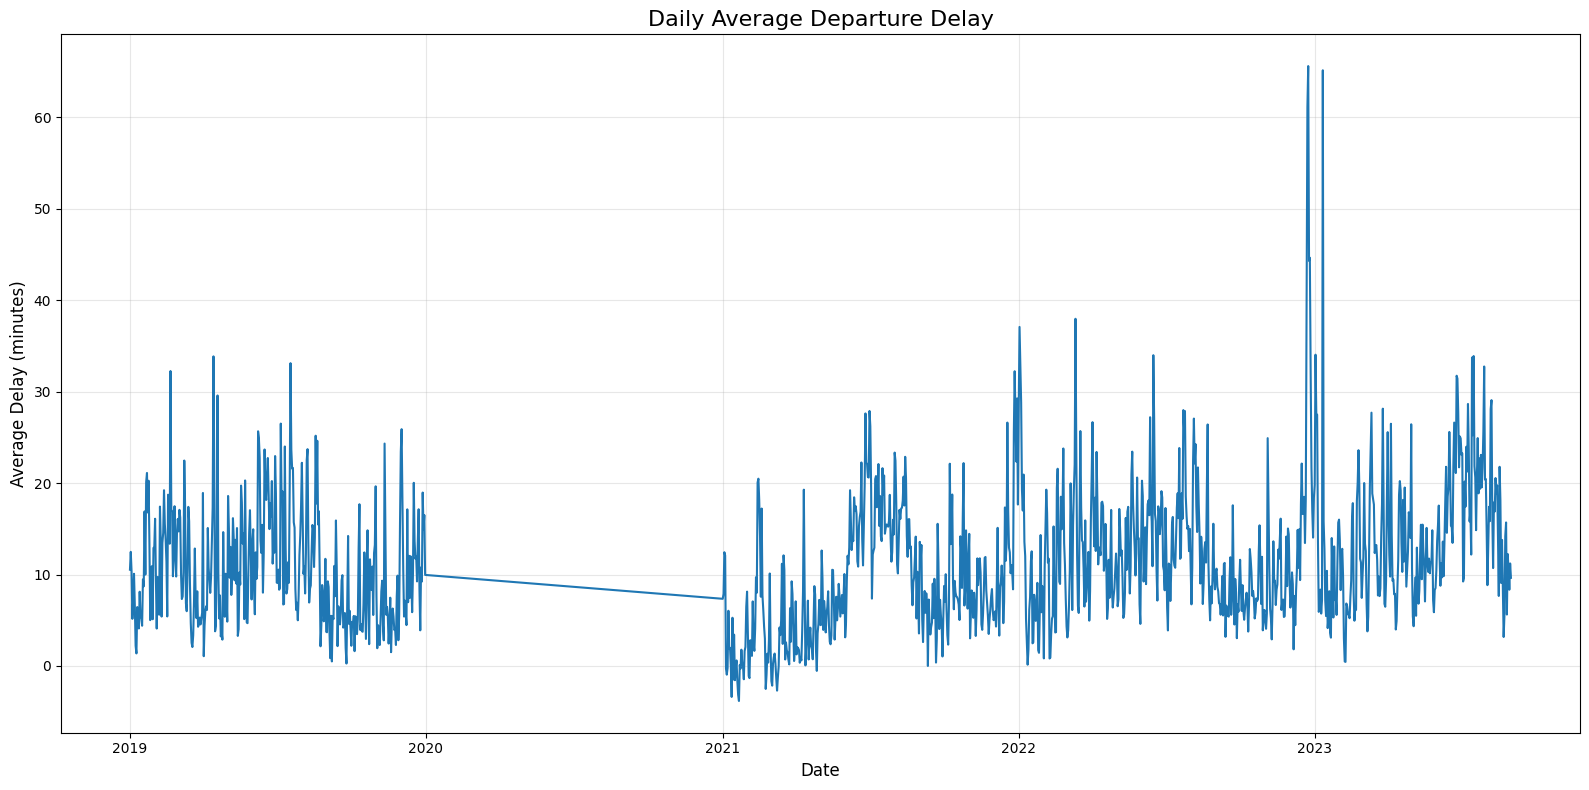

In [71]:
# Create and analyze daily aggregated time series
ts_daily = aggregate_to_time_series(load_processed_data(BASE_PROCESSED_PATH), agg_level='daily')

print(f"Daily time series shape: {ts_daily.shape}")
print("\nFirst few rows:")
display(ts_daily.head())

# Check the date range
print(f"Date range: {ts_daily.index.min()} to {ts_daily.index.max()}")
print(f"Total days: {len(ts_daily)}")

# Plot the time series
plt.figure(figsize=(16, 8))
plt.plot(ts_daily.index, ts_daily['avg_delay'], linewidth=1.5)
plt.title('Daily Average Departure Delay', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [72]:
# Check for stationarity
def check_stationarity(ts, column='avg_delay'):
    """
    Check if a time series is stationary using the Augmented Dickey-Fuller test
    """
    # Calculate rolling statistics
    rolling_mean = ts[column].rolling(window=7).mean()
    rolling_std = ts[column].rolling(window=7).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(16, 8))
    plt.subplot(211)
    plt.plot(ts.index, ts[column], label='Original')
    plt.plot(ts.index, rolling_mean, label='Rolling Mean (7-day)')
    plt.plot(ts.index, rolling_std, label='Rolling Std (7-day)')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Perform ADF test
    result = adfuller(ts[column].dropna())
    
    plt.subplot(212)
    plt.bar(['ADF Statistic', 'p-value', '1%', '5%', '10%'], 
            [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']], 
            color=['blue', 'red', 'green', 'green', 'green'])
    plt.axhline(y=result[4]['5%'], color='green', linestyle='-', alpha=0.5)
    plt.title('Augmented Dickey-Fuller Test Results', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print test results
    print('Augmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    # Interpret results
    if result[1] <= 0.05:
        print("\nConclusion: Time series is stationary (reject null hypothesis)")
        return True
    else:
        print("\nConclusion: Time series is non-stationary (fail to reject null hypothesis)")
        return False

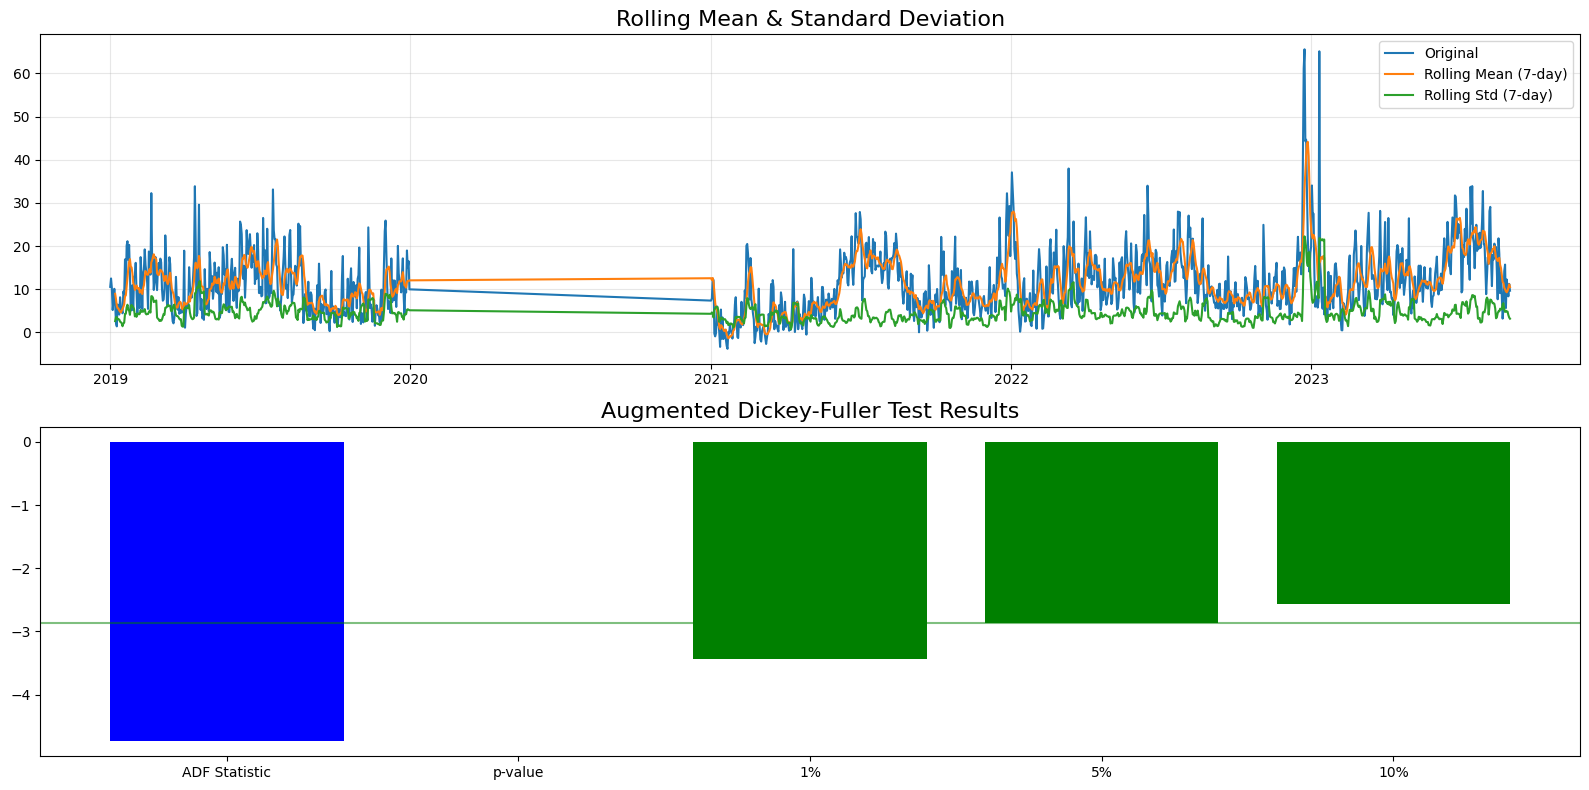

Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.7388
p-value: 0.0001
Critical Values:
   1%: -3.4353
   5%: -2.8637
   10%: -2.5679

Conclusion: Time series is stationary (reject null hypothesis)


In [73]:
# Check stationarity of the daily average delay time series
is_stationary = check_stationarity(ts_daily)

# If not stationary, demonstrate differencing
if not is_stationary:
    # First-order differencing
    ts_daily['diff1'] = ts_daily['avg_delay'].diff().dropna()
    
    # Check stationarity of differenced series
    print("\nChecking stationarity after first-order differencing:")
    is_stationary_diff1 = check_stationarity(ts_daily.dropna(), column='diff1')

In [74]:
# Seasonal decomposition (annual seasonality)
def decompose_time_series(ts, column='avg_delay'):
    """
    Decompose time series into trend, seasonal, and residual components (annual seasonality)
    """
    # Fill any missing values with forward fill
    ts_filled = ts[column].fillna(method='ffill')
    # Use period=365 for annual seasonality
    if len(ts_filled) < 730:  # At least 2 years of data for annual seasonality
        print("Not enough data for annual decomposition")
        return None
    try:
        decomposition = seasonal_decompose(ts_filled, model='additive', period=365)
        # Plot decomposition
        plt.figure(figsize=(16, 12))
        plt.subplot(411)
        plt.plot(decomposition.observed)
        plt.title('Observed', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title('Trend', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonality (Annual)', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title('Residuals', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        return decomposition
    except Exception as e:
        print(f"Error during annual decomposition: {e}")
        return None

In [75]:
# Analyze ACF and PACF plots for time series modeling
def analyze_acf_pacf(ts, column='avg_delay', lags=40):
    """
    Analyze auto-correlation and partial auto-correlation functions
    """
    # Fill missing values
    ts_filled = ts[column].fillna(method='ffill')
    
    # Create the plots
    plt.figure(figsize=(16, 8))
    
    plt.subplot(211)
    plot_acf(ts_filled, lags=lags, alpha=0.05, title='Autocorrelation Function (ACF)', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    
    plt.subplot(212)
    plot_pacf(ts_filled, lags=lags, alpha=0.05, method='ols', title='Partial Autocorrelation Function (PACF)', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

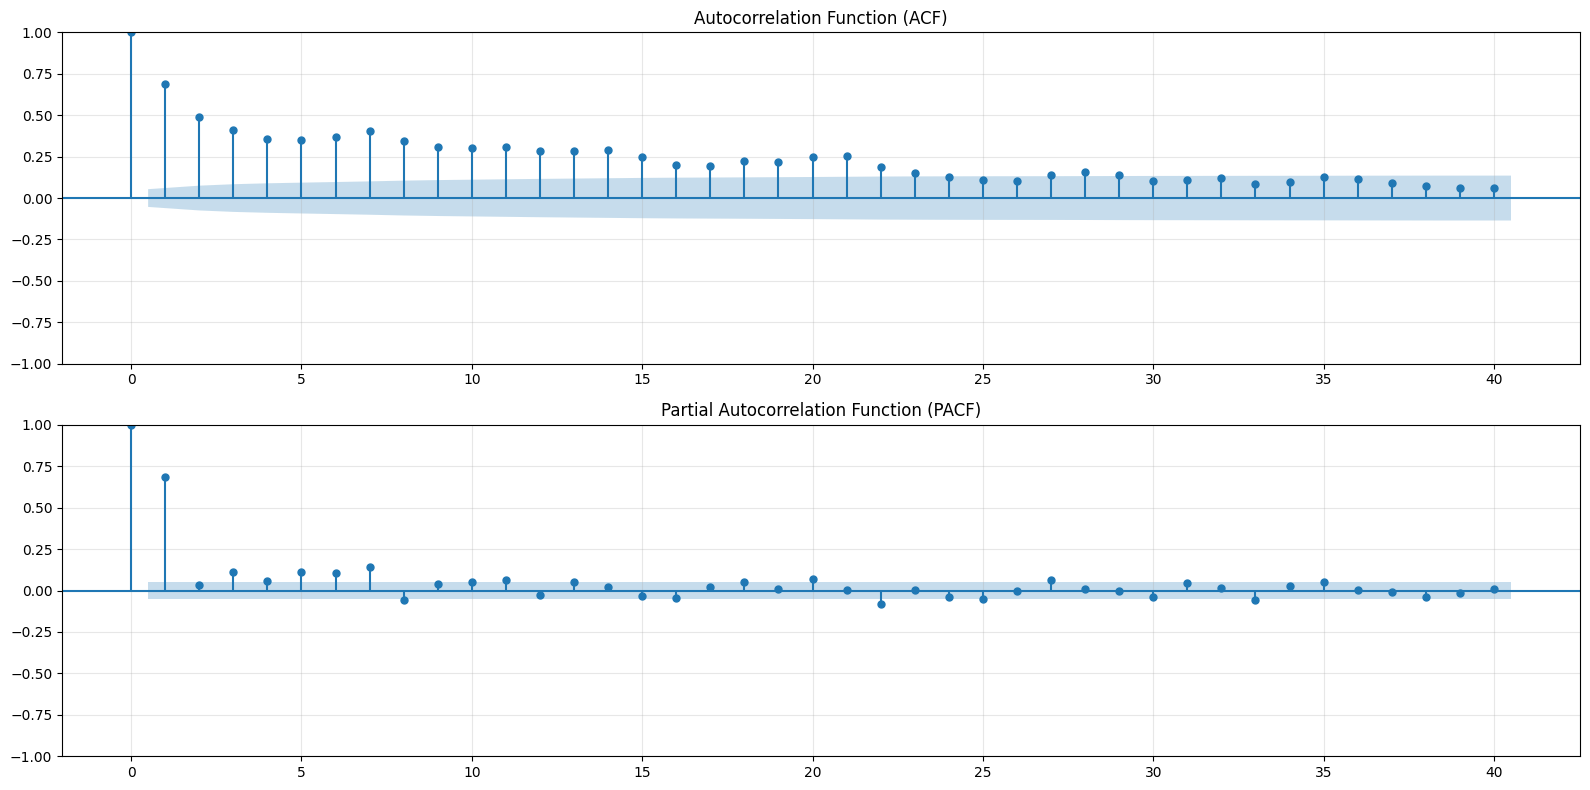

In [76]:
# Analyze ACF and PACF to guide model selection
analyze_acf_pacf(ts_daily)

## Feature Engineering for Time Series Models

Based on our analysis, we'll create features specifically designed for time series forecasting. These include:
1. Lag features
2. Rolling statistics
3. Seasonal indicators
4. Holiday indicators
5. External regressors (e.g., weather data, if available)

In [77]:
# Create time series features for forecasting
def create_ts_features(ts_data):
    """
    Create features for time series forecasting
    """
    # Make a copy to avoid modifying the original data
    ts = ts_data.copy()
    
    # ======== LAG FEATURES ========
    # Create lags of the target variable (useful for autoregressive models)
    for lag in [1, 2, 3, 7, 14, 21, 28]:  # Daily, weekly, and monthly lags
        ts[f'avg_delay_lag{lag}'] = ts['avg_delay'].shift(lag)
    
    # ======== ROLLING WINDOW FEATURES ========
    # Create rolling statistics
    for window in [3, 7, 14, 28]:
        ts[f'avg_delay_roll_mean{window}'] = ts['avg_delay'].rolling(window=window).mean()
        ts[f'avg_delay_roll_std{window}'] = ts['avg_delay'].rolling(window=window).std()
        ts[f'avg_delay_roll_max{window}'] = ts['avg_delay'].rolling(window=window).max()
        ts[f'avg_delay_roll_min{window}'] = ts['avg_delay'].rolling(window=window).min()
    
    # ======== CALENDAR FEATURES ========
    # Extract date components
    if isinstance(ts.index, pd.DatetimeIndex):
        # Add calendar features
        ts['month'] = ts.index.month
        ts['day_of_week'] = ts.index.dayofweek  # 0=Monday, 6=Sunday
        ts['day_of_year'] = ts.index.dayofyear
        ts['quarter'] = ts.index.quarter
        ts['week_of_year'] = ts.index.isocalendar().week
        
        # Add cyclical encoding of calendar features
        ts['month_sin'] = np.sin(2 * np.pi * ts['month'] / 12)
        ts['month_cos'] = np.cos(2 * np.pi * ts['month'] / 12)
        ts['day_of_week_sin'] = np.sin(2 * np.pi * ts['day_of_week'] / 7)
        ts['day_of_week_cos'] = np.cos(2 * np.pi * ts['day_of_week'] / 7)
        
        # Create weekend indicator
        ts['is_weekend'] = (ts['day_of_week'] >= 5).astype(int)
    
    # ======== TREND FEATURES ========
    # Create a simple trend feature (days since start)
    if isinstance(ts.index, pd.DatetimeIndex):
        ts['trend'] = (ts.index - ts.index.min()).days
    
    return ts

In [78]:
# Create holiday indicators
def add_holiday_indicators(ts_data):
    """
    Add holiday indicators to the time series data
    """
    # Make a copy to avoid modifying the original data
    ts = ts_data.copy()
    
    # Check that index is a datetime index
    if not isinstance(ts.index, pd.DatetimeIndex):
        print("Error: Index is not a DatetimeIndex")
        return ts
    
    # Initialize holiday columns
    ts['is_holiday'] = 0
    ts['is_holiday_season'] = 0
    
    # Get years in the data
    years = ts.index.year.unique()
    
    # Define major US holidays (simplified version)
    holidays = []
    for year in years:
        # New Year's Day
        holidays.append(pd.Timestamp(year=year, month=1, day=1))
        
        # Memorial Day (last Monday in May)
        memorial_day = pd.Timestamp(year=year, month=5, day=31)
        memorial_day = memorial_day - pd.Timedelta(days=(memorial_day.dayofweek - 0) % 7)
        holidays.append(memorial_day)
        
        # Independence Day
        holidays.append(pd.Timestamp(year=year, month=7, day=4))
        
        # Labor Day (first Monday in September)
        labor_day = pd.Timestamp(year=year, month=9, day=1)
        labor_day = labor_day + pd.Timedelta(days=(0 - labor_day.dayofweek) % 7)
        holidays.append(labor_day)
        
        # Thanksgiving (fourth Thursday in November)
        thanksgiving = pd.Timestamp(year=year, month=11, day=1)
        thanksgiving = thanksgiving + pd.Timedelta(days=(3 - thanksgiving.dayofweek) % 7 + 21)
        holidays.append(thanksgiving)
        
        # Christmas
        holidays.append(pd.Timestamp(year=year, month=12, day=25))
    
    # Mark holidays
    for holiday in holidays:
        # Mark the actual holiday
        if holiday in ts.index:
            ts.loc[holiday, 'is_holiday'] = 1
        
        # Mark days before and after as holiday-adjacent (for travel effects)
        for i in range(1, 3):  # 1-2 days before and after
            before = holiday - pd.Timedelta(days=i)
            after = holiday + pd.Timedelta(days=i)
            
            if before in ts.index:
                ts.loc[before, 'is_holiday'] = 0.5  # Half weight for adjacent days
            
            if after in ts.index:
                ts.loc[after, 'is_holiday'] = 0.5  # Half weight for adjacent days
    
    # Mark holiday seasons (Nov 15 - Jan 15)
    for year in years:
        # Thanksgiving to New Year's season
        season_start = pd.Timestamp(year=year, month=11, day=15)
        season_end = pd.Timestamp(year=year+1, month=1, day=15)
        
        # Mark the holiday season
        mask = (ts.index >= season_start) & (ts.index <= season_end)
        ts.loc[mask, 'is_holiday_season'] = 1
    
    return ts

In [79]:
# Process features for time series forecasting
ts_daily_featured = create_ts_features(ts_daily)
ts_daily_featured = add_holiday_indicators(ts_daily_featured)

print(f"Time series with features shape: {ts_daily_featured.shape}")
print("\nFeatures created:")
for col in ts_daily_featured.columns:
    print(f"- {col}")

# Show a sample of the featured data
display(ts_daily_featured.head())

Time series with features shape: (1338, 42)

Features created:
- avg_delay
- median_delay
- max_delay
- min_delay
- std_delay
- num_flights
- avg_delay_lag1
- avg_delay_lag2
- avg_delay_lag3
- avg_delay_lag7
- avg_delay_lag14
- avg_delay_lag21
- avg_delay_lag28
- avg_delay_roll_mean3
- avg_delay_roll_std3
- avg_delay_roll_max3
- avg_delay_roll_min3
- avg_delay_roll_mean7
- avg_delay_roll_std7
- avg_delay_roll_max7
- avg_delay_roll_min7
- avg_delay_roll_mean14
- avg_delay_roll_std14
- avg_delay_roll_max14
- avg_delay_roll_min14
- avg_delay_roll_mean28
- avg_delay_roll_std28
- avg_delay_roll_max28
- avg_delay_roll_min28
- month
- day_of_week
- day_of_year
- quarter
- week_of_year
- month_sin
- month_cos
- day_of_week_sin
- day_of_week_cos
- is_weekend
- trend
- is_holiday
- is_holiday_season


,avg_delay,median_delay,max_delay,min_delay,std_delay,num_flights,avg_delay_lag1,avg_delay_lag2,avg_delay_lag3,avg_delay_lag7,avg_delay_lag14,avg_delay_lag21,avg_delay_lag28,avg_delay_roll_mean3,avg_delay_roll_std3,avg_delay_roll_max3,avg_delay_roll_min3,avg_delay_roll_mean7,avg_delay_roll_std7,avg_delay_roll_max7,avg_delay_roll_min7,avg_delay_roll_mean14,avg_delay_roll_std14,avg_delay_roll_max14,avg_delay_roll_min14,avg_delay_roll_mean28,avg_delay_roll_std28,avg_delay_roll_max28,avg_delay_roll_min28,month,day_of_week,day_of_year,quarter,week_of_year,month_sin,month_cos,day_of_week_sin,day_of_week_cos,is_weekend,trend,is_holiday,is_holiday_season
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,10.529989,-1.004907,341.0,-30.0,30.763833,1834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,0.5,0.866025,0.781831,0.623490,0,0,1.0,0
2019-01-02,12.479763,-0.599704,818.0,-19.0,42.575954,2026.0,10.529989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,1,1,0.5,0.866025,0.974928,-0.222521,0,1,0.5,0
2019-01-03,10.310448,-1.690547,1394.0,-26.0,48.035198,2010.0,12.479763,10.529989,NaN,NaN,NaN,NaN,NaN,11.106733,1.194135,12.479763,10.310448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,3,1,1,0.5,0.866025,0.433884,-0.900969,0,2,0.5,0
2019-01-04,5.157555,-2.208250,672.0,-41.0,42.244972,2012.0,10.310448,12.479763,10.529989,NaN,NaN,NaN,NaN,9.315922,3.761050,12.479763,5.157555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,4,1,1,0.5,0.866025,-0.433884,-0.900969,0,3,0.0,0
2019-01-05,7.342874,-2.428154,667.0,-20.0,44.961260,1712.0,5.157555,10.310448,12.479763,NaN,NaN,NaN,NaN,7.603625,2.586324,10.310448,5.157555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,5,1,1,0.5,0.866025,-0.974928,-0.222521,1,4,0.0,0


Train set: 1095 days from 2019-01-01 00:00:00 to 2022-12-31 00:00:00
Test set: 243 days from 2023-01-01 00:00:00 to 2023-08-31 00:00:00


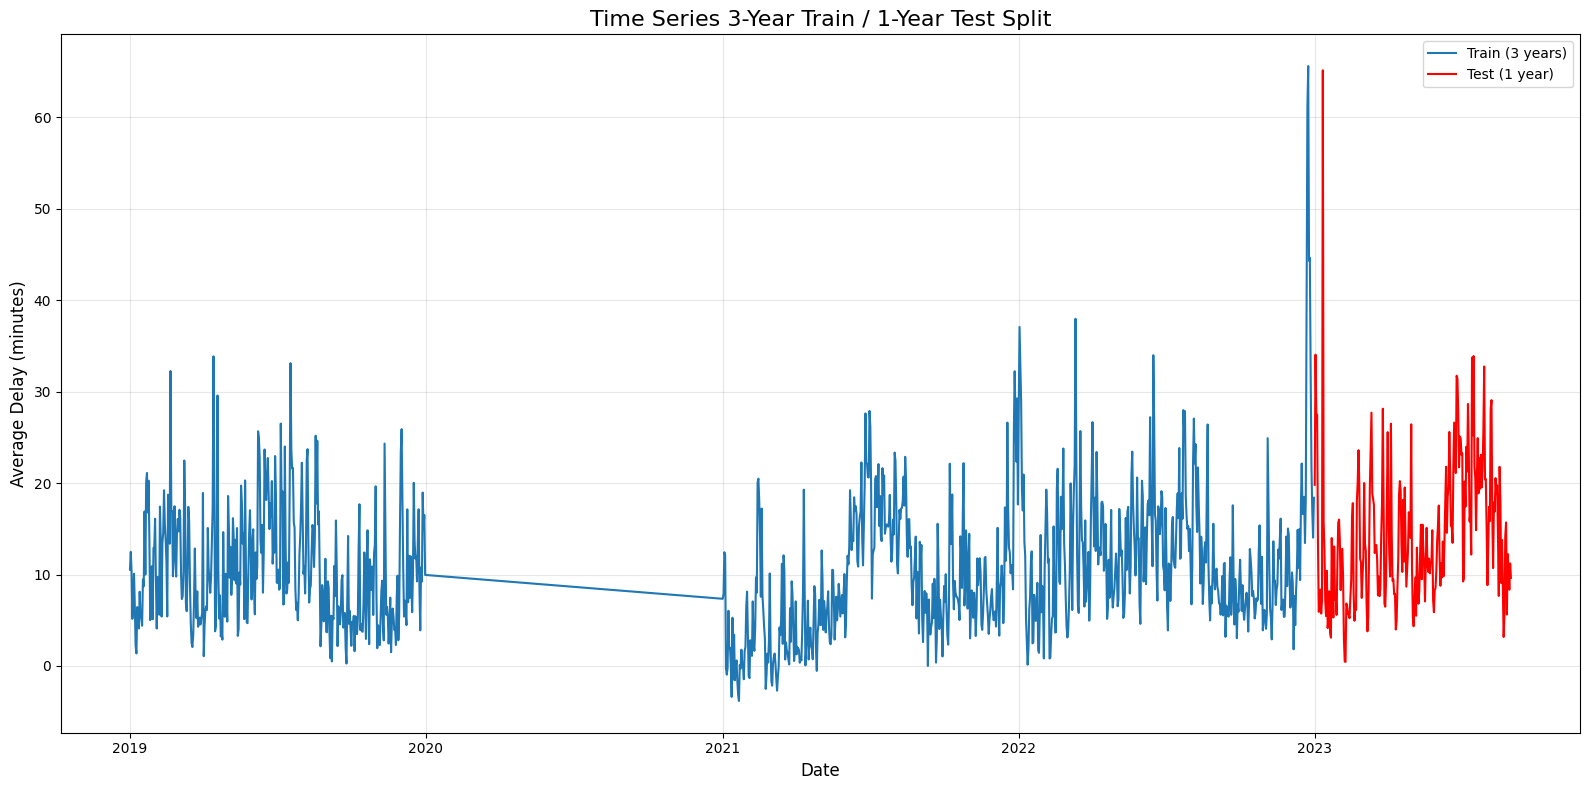

In [80]:
# Create train-test split for time series: 3 years for training, 1 year for testing
# This replaces the previous ts_train_test_split logic

def ts_split_3y_train_1y_test(ts_data):
    """
    Split the time series into 3 years for training and 1 year for testing.
    Returns train, test DataFrames.
    """
    ts_sorted = ts_data.sort_index()
    years = ts_sorted.index.year.unique()
    if len(years) < 4:
        print("Not enough years in the data for a 3-year/1-year split.")
        return None, None
    # Get the first 3 years for training
    train_years = years[:3]
    test_year = years[3]
    train = ts_sorted[ts_sorted.index.year.isin(train_years)]
    test = ts_sorted[ts_sorted.index.year == test_year]
    print(f"Train set: {len(train)} days from {train.index.min()} to {train.index.max()}")
    print(f"Test set: {len(test)} days from {test.index.min()} to {test.index.max()}")
    return train, test

# Apply the custom split to the daily featured time series (after feature engineering and imputation)
ts_train_3y, ts_test_1y = ts_split_3y_train_1y_test(ts_daily_featured_imputed)

# Visualize the split
plt.figure(figsize=(16, 8))
plt.plot(ts_train_3y.index, ts_train_3y['avg_delay'], label='Train (3 years)')
plt.plot(ts_test_1y.index, ts_test_1y['avg_delay'], label='Test (1 year)', color='red')
plt.title('Time Series 3-Year Train / 1-Year Test Split', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

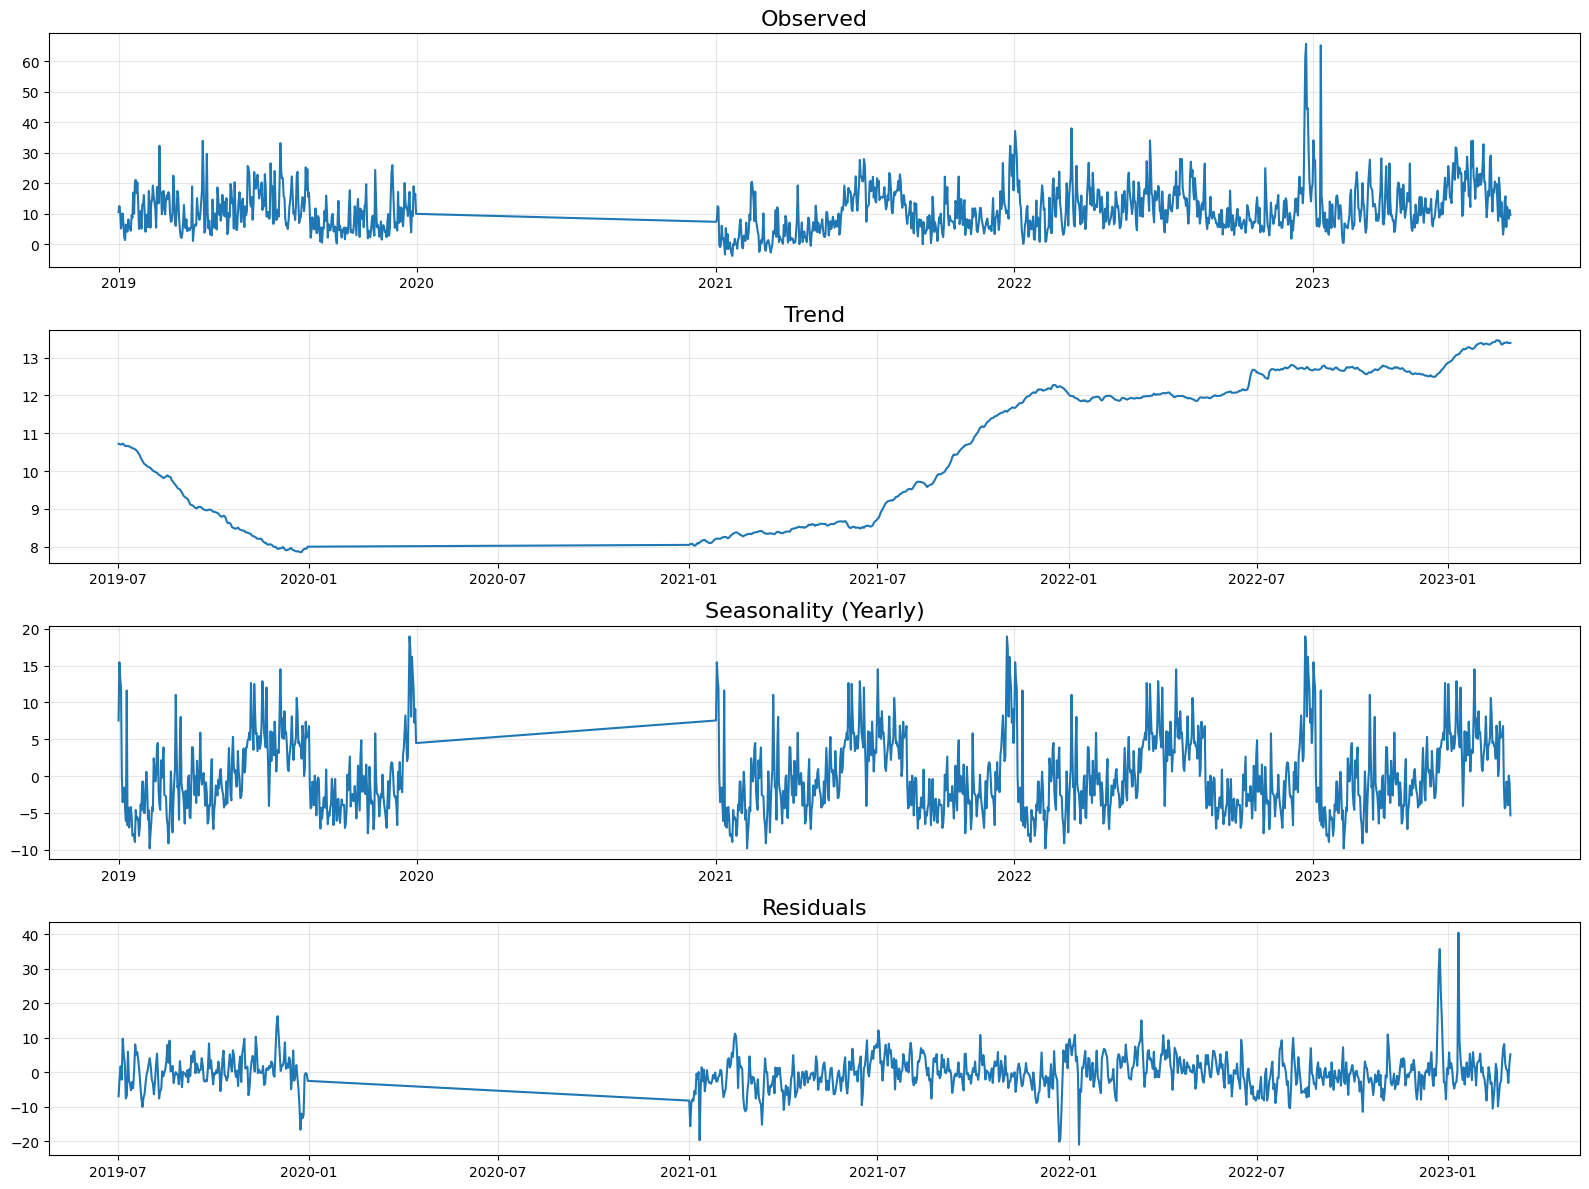

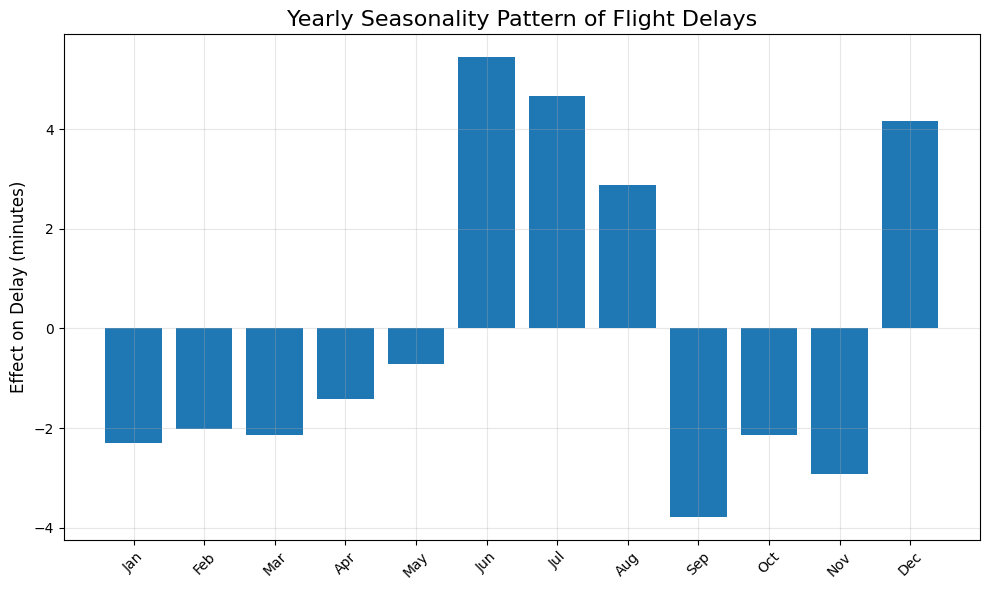

In [81]:
# Seasonal decomposition (annual, not weekly)
def decompose_time_series_yearly(ts, column='avg_delay'):
    """
    Decompose time series into trend, yearly seasonal, and residual components
    """
    ts_filled = ts[column].fillna(method='ffill')
    # Use period=365 for yearly seasonality
    if len(ts_filled) < 730:  # At least 2 years of data for yearly seasonality
        print("Not enough data for yearly decomposition")
        return None
    try:
        decomposition = seasonal_decompose(ts_filled, model='additive', period=365)
        # Plot decomposition
        plt.figure(figsize=(16, 12))
        plt.subplot(411)
        plt.plot(decomposition.observed)
        plt.title('Observed', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title('Trend', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonality (Yearly)', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title('Residuals', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        return decomposition
    except Exception as e:
        print(f"Error during yearly decomposition: {e}")
        return None

# Decompose and plot yearly seasonality

decomposition = decompose_time_series_yearly(ts_daily)

if decomposition is not None:
    seasonal = decomposition.seasonal
    seasonal_df = pd.DataFrame({'seasonal': seasonal})
    seasonal_df['month'] = seasonal_df.index.month
    monthly_seasonality = seasonal_df.groupby('month')['seasonal'].mean()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.figure(figsize=(10, 6))
    plt.bar(months, monthly_seasonality)
    plt.title('Yearly Seasonality Pattern of Flight Delays', fontsize=16)
    plt.ylabel('Effect on Delay (minutes)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

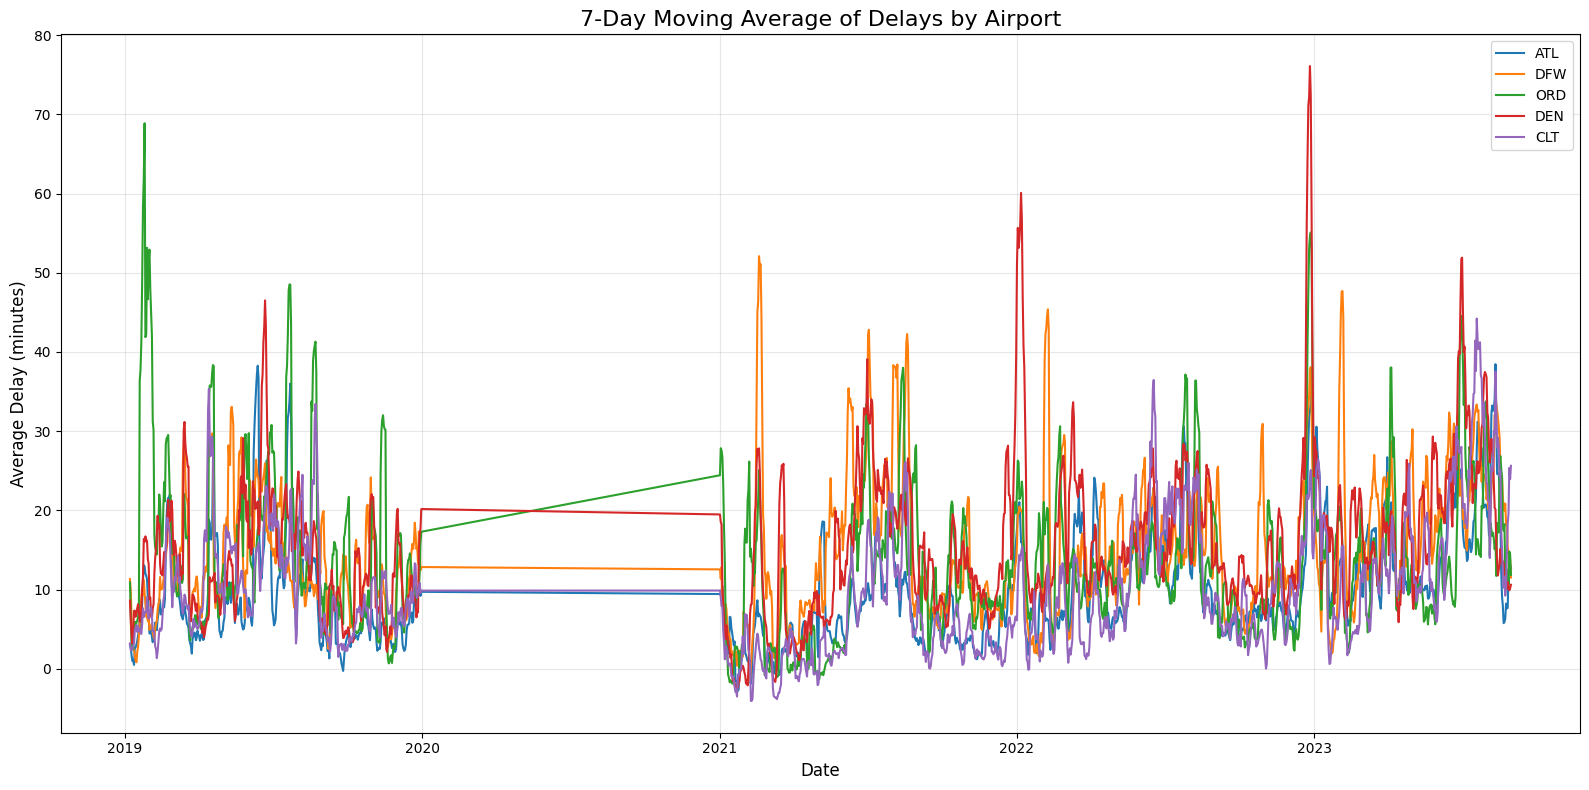

In [82]:
# Visualize time series for top airports
plt.figure(figsize=(16, 8))

# Get top 5 airports
top_5_airports = top_airports.index

# Create a 7-day moving average for each airport
for airport in top_5_airports:
    try:
        airport_data = ts_airport.xs(airport, level=1)
        plt.plot(airport_data.index, 
                 airport_data['avg_delay'].rolling(window=7).mean(), 
                 label=airport)
    except Exception as e:
        print(f"Error plotting {airport}: {e}")

plt.title('7-Day Moving Average of Delays by Airport', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Save Processed Time Series Data

We'll save the processed time series data in both CSV and pickle formats for use in time series modeling.

In [83]:
# Save processed time series data
def save_ts_data(ts_data, name, output_dir):
    """
    Save time series data in multiple formats
    """
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save as CSV
    csv_path = os.path.join(output_dir, f"{name}.csv")
    ts_data.to_csv(csv_path)
    
    # Save as pickle
    pickle_path = os.path.join(output_dir, f"{name}.pkl")
    ts_data.to_pickle(pickle_path)
    
    print(f"Saved {name} to:")
    print(f"- CSV: {csv_path}")
    print(f"- Pickle: {pickle_path}")
    
    return csv_path, pickle_path

In [84]:
# Save the daily time series with features
save_ts_data(ts_daily_featured_imputed, "daily_delay_ts", TS_PROCESSED_PATH)

# Save airport-level time series
if 'ts_airport' in locals() and ts_airport is not None:
    save_ts_data(ts_airport, "airport_delay_ts", TS_PROCESSED_PATH)

# Save carrier-level time series
if 'ts_carrier' in locals() and ts_carrier is not None:
    save_ts_data(ts_carrier, "carrier_delay_ts", TS_PROCESSED_PATH)

# Save train-test-validation splits
if 'train_ts' in locals() and 'val_ts' in locals() and 'test_ts' in locals():
    save_ts_data(train_ts, "train_ts", TS_PROCESSED_PATH)
    save_ts_data(val_ts, "val_ts", TS_PROCESSED_PATH)
    save_ts_data(test_ts, "test_ts", TS_PROCESSED_PATH)

Saved daily_delay_ts to:
- CSV: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\daily_delay_ts.csv
- Pickle: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\daily_delay_ts.pkl
Saved airport_delay_ts to:
- CSV: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\airport_delay_ts.csv
- Pickle: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\airport_delay_ts.pkl
Saved train_ts to:
- CSV: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\train_ts.csv
- Pickle: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\train_ts.pkl
Saved val_ts to:
- CSV: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\val_ts.csv
- Pickle: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\val_ts.pkl
Saved test_ts to:
- CSV: c:\xampp\htdocs\Forecasting_Flights-DataScience\dat

## Time Series Cross-Validation

For time series, standard cross-validation isn't appropriate. We'll implement time series-specific cross-validation strategies.

In [85]:
# Time series cross-validation function
def ts_cross_validation(ts_data, n_splits=3, test_days=7, val_days=7):
    """
    Create time series cross-validation folds
    
    Parameters:
    -----------
    ts_data : pandas.DataFrame
        Time series data with DatetimeIndex
    n_splits : int
        Number of validation folds to create
    test_days : int
        Number of days to include in each test fold
    val_days : int
        Number of days to include in each validation fold
        
    Returns:
    --------
    list of tuples
        Each tuple contains (train, val, test) for a fold
    """
    # Sort the data by date
    ts_sorted = ts_data.sort_index()
    
    # Calculate the size of each fold
    fold_size = test_days + val_days
    
    # List to store the folds
    folds = []
    
    # Create folds
    for i in range(n_splits):
        # Calculate the end of this fold
        fold_end = ts_sorted.index[-1] - pd.Timedelta(days=i*fold_size)
        test_start = fold_end - pd.Timedelta(days=test_days)
        val_start = test_start - pd.Timedelta(days=val_days)
        
        # Create the train, validation, and test sets
        test = ts_sorted[(ts_sorted.index > test_start) & (ts_sorted.index <= fold_end)]
        val = ts_sorted[(ts_sorted.index > val_start) & (ts_sorted.index <= test_start)]
        train = ts_sorted[ts_sorted.index <= val_start]
        
        # Append to folds list
        folds.append((train, val, test))
    
    return folds

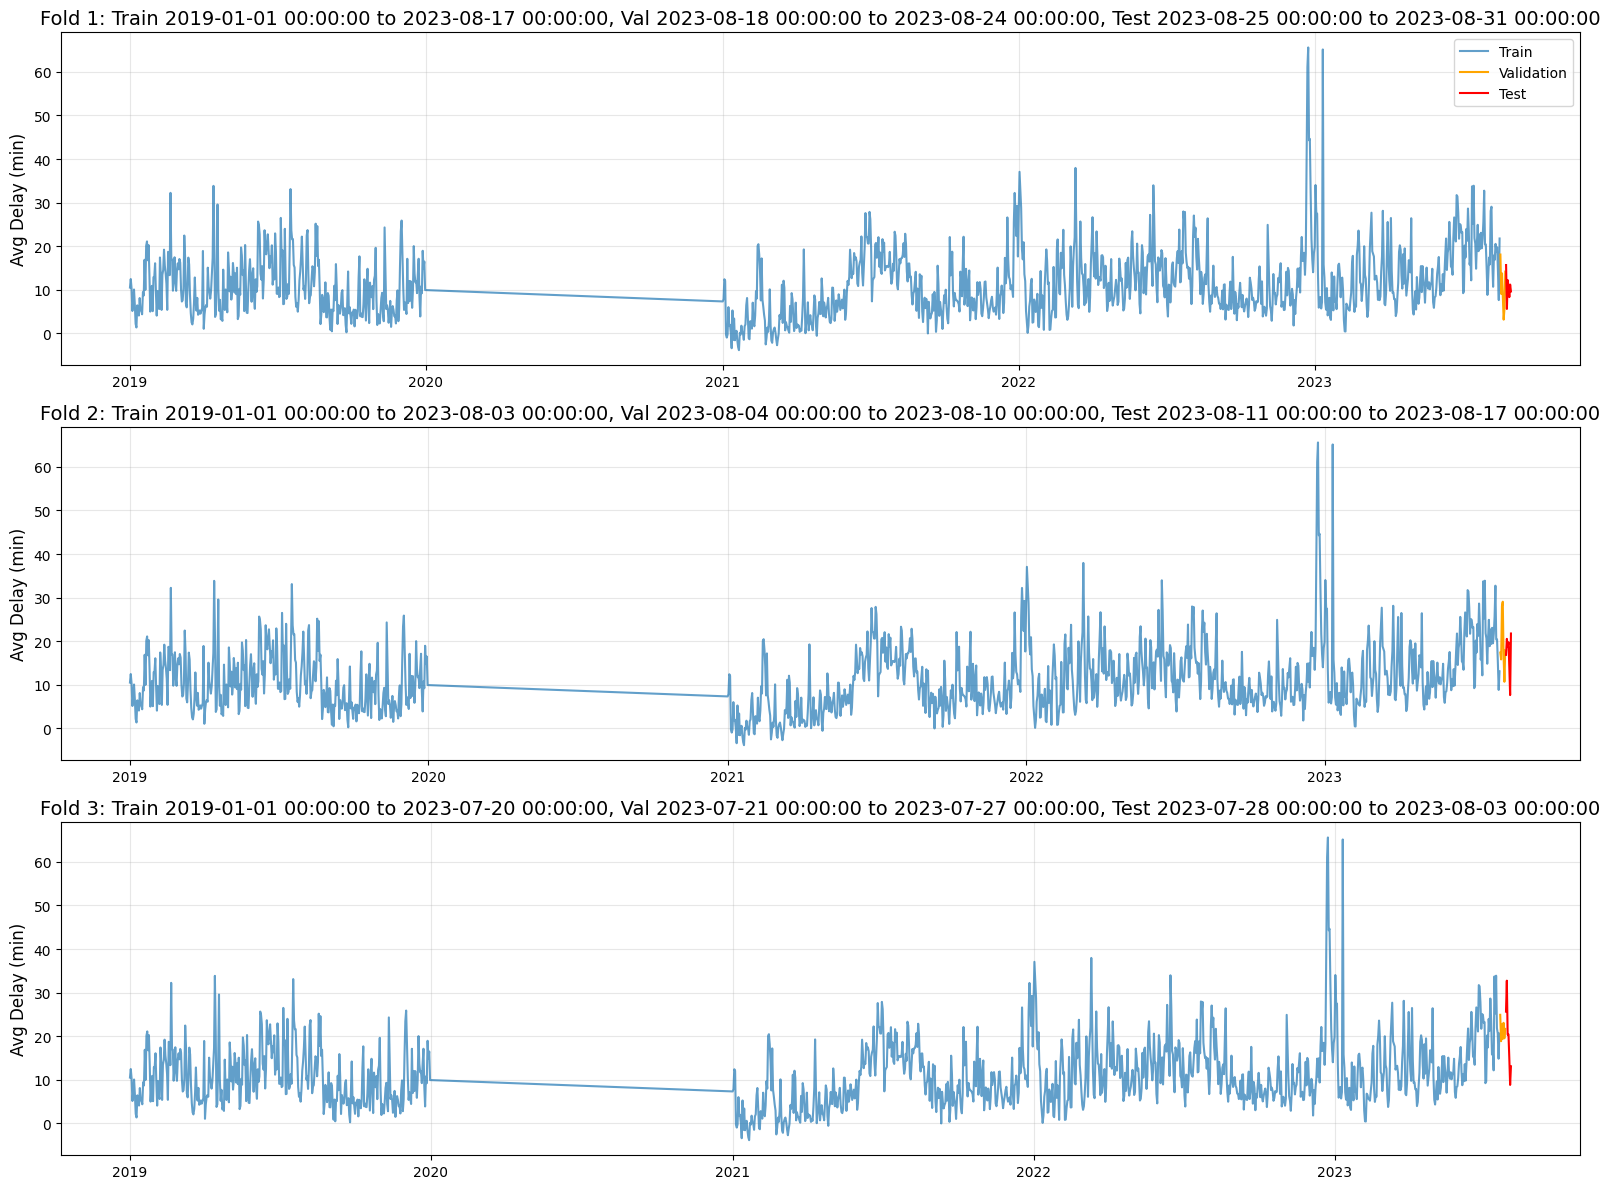

In [86]:
# Demonstrate time series cross-validation
cv_folds = ts_cross_validation(ts_daily_featured_imputed, n_splits=3)

# Visualize CV folds
plt.figure(figsize=(16, 12))

for i, (train, val, test) in enumerate(cv_folds):
    plt.subplot(len(cv_folds), 1, i+1)
    
    plt.plot(train.index, train['avg_delay'], label='Train', alpha=0.7)
    plt.plot(val.index, val['avg_delay'], label='Validation', color='orange')
    plt.plot(test.index, test['avg_delay'], label='Test', color='red')
    
    plt.title(f'Fold {i+1}: Train {train.index[0]} to {train.index[-1]}, '
              f'Val {val.index[0]} to {val.index[-1]}, Test {test.index[0]} to {test.index[-1]}', 
              fontsize=14)
    plt.ylabel('Avg Delay (min)', fontsize=12)
    
    if i == 0:
        plt.legend()
    
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Create Model-Ready Data for Different Time Series Algorithms

Different time series models have different data format requirements. Let's prepare data specifically for:
1. ARIMA/SARIMA models
2. Prophet models
3. Neural network-based forecasting (e.g., LSTM)

In [87]:
# Create data formatted for different time series algorithms

# 1. Format for ARIMA/SARIMA
def format_for_arima(ts_data, target_col='avg_delay'):
    """Format data for ARIMA/SARIMA models"""
    # For ARIMA, we typically need just the target variable as a series
    arima_data = ts_data[target_col].copy()
    
    # For SARIMAX with exogenous variables, we can include other features
    exog_cols = [col for col in ts_data.columns if col != target_col and
                col not in ['avg_delay_lag1', 'avg_delay_lag2', 'avg_delay_lag3']]  # Exclude lags
    
    # Create exogenous variables dataframe
    exog_data = ts_data[exog_cols].copy() if exog_cols else None
    
    return arima_data, exog_data

# 2. Format for Prophet
def format_for_prophet(ts_data, target_col='avg_delay'):
    """Format data for Facebook Prophet"""
    # Prophet requires a specific DataFrame format with 'ds' and 'y' columns
    prophet_data = pd.DataFrame({
        'ds': ts_data.index,
        'y': ts_data[target_col]
    })
    
    # Add additional regressors (optional)
    for col in ts_data.columns:
        if col != target_col and 'lag' not in col:  # Exclude lags
            prophet_data[col] = ts_data[col]
    
    return prophet_data

# 3. Format for ML-based forecasting (LSTM)
def format_for_lstm(ts_data, target_col='avg_delay', seq_length=7):
    """Format data for LSTM models"""
    # For LSTM, we need sequences of data
    # Prepare the data
    data = ts_data.copy()
    
    # Create sequences
    X = []
    y = []
    
    for i in range(len(data) - seq_length):
        # Get sequence of features
        features = data.iloc[i:i+seq_length].drop(columns=[target_col])
        # Get target value (next day's value)
        target = data.iloc[i+seq_length][target_col]
        
        X.append(features.values)
        y.append(target)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Get feature names for reference
    feature_names = data.drop(columns=[target_col]).columns
    
    return X, y, feature_names

In [88]:
# Create model-ready data examples

# Create ARIMA/SARIMA format data
arima_data, arima_exog = format_for_arima(train_ts)
print(f"ARIMA data shape: {arima_data.shape}")
if arima_exog is not None:
    print(f"ARIMA exogenous data shape: {arima_exog.shape}")

# Create Prophet format data
prophet_data = format_for_prophet(train_ts)
print(f"\nProphet data shape: {prophet_data.shape}")
print("Prophet data columns:", prophet_data.columns.tolist()[:10], "...")

# Create LSTM format data
lstm_X, lstm_y, lstm_features = format_for_lstm(train_ts)
print(f"\nLSTM X shape: {lstm_X.shape}")
print(f"LSTM y shape: {lstm_y.shape}")
print(f"LSTM features: {len(lstm_features)} columns")

ARIMA data shape: (1293,)
ARIMA exogenous data shape: (1293, 38)

Prophet data shape: (1293, 36)
Prophet data columns: ['ds', 'y', 'median_delay', 'max_delay', 'min_delay', 'std_delay', 'num_flights', 'avg_delay_roll_mean3', 'avg_delay_roll_std3', 'avg_delay_roll_max3'] ...

LSTM X shape: (1286, 7, 41)
LSTM y shape: (1286,)
LSTM features: 41 columns

LSTM X shape: (1286, 7, 41)
LSTM y shape: (1286,)
LSTM features: 41 columns


In [89]:
# Save model-ready data
def save_model_ready_data(data_dict, output_dir):
    """Save model-ready data for different algorithms"""
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save each item in the dictionary
    for name, data in data_dict.items():
        # Define the file path
        file_path = os.path.join(output_dir, f"{name}.pkl")
        
        # Save the data
        with open(file_path, 'wb') as f:
            pickle.dump(data, f)
        
        print(f"Saved {name} to {file_path}")

# Create a dictionary of data to save
model_ready_data = {
    'arima_data': arima_data,
    'arima_exog': arima_exog,
    'prophet_data': prophet_data,
    'lstm_data': (lstm_X, lstm_y, lstm_features)
}

# Save the data
save_model_ready_data(model_ready_data, os.path.join(TS_PROCESSED_PATH, 'model_ready'))

Saved arima_data to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\arima_data.pkl
Saved arima_exog to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\arima_exog.pkl
Saved prophet_data to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\prophet_data.pkl
Saved lstm_data to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\lstm_data.pkl


## Summary of Time Series Preprocessing

The time series preprocessing pipeline has:

1. Aggregated flight data at different temporal and entity levels (daily, airport, carrier)
2. Analyzed time series characteristics including stationarity and seasonality
3. Created lag features, rolling statistics, and seasonal indicators
4. Prepared train-test splits with time-based validation
5. Implemented time series cross-validation strategies
6. Formatted data for different time series algorithms (ARIMA, Prophet, LSTM)
7. Saved processed data in multiple formats for time series modeling

This time series-ready dataset is optimized for forecasting models and includes features designed to capture temporal patterns in flight delays. The preprocessing ensures proper handling of time-based dependencies and provides multiple aggregation levels for different forecasting tasks.